In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns

# sns.set_context('talk|')?
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools


In [2]:
type = "scaled_inverse_cdf"

In [3]:
tools.scaling

1.5

2.0
42.0


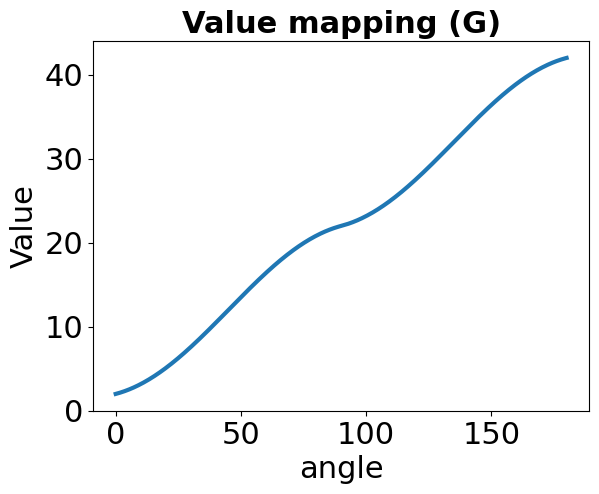

In [26]:
plt.plot(tools.stim_ori_grid*90/np.pi, tools.value_function_ori(tools.stim_ori_grid, type))
# plt.plot(tools.stim_ori_grid*90/np.pi, tools.value_function_ori(tools.stim_ori_grid, "cdf_prior"))
# plt.plot(tools.stim_ori_grid,(integrate.cumtrapz(tools.prior_ori(tools.stim_ori_grid), tools.stim_ori_grid, initial=0.0))*tools.factor_val+tools.min_val)


# plt.plot((tools.stim_ori_grid*90/np.pi),(tools.value_function_ori((tools.stim_ori_grid), type = "cdf_prior")))

plt.ylabel("Value")
plt.xlabel("angle")
plt.title("Value mapping (G)", size = 22,fontweight="bold")

print(min(tools.value_function_ori(tools.stim_ori_grid, type)))

print(max(tools.value_function_ori(tools.stim_ori_grid, type)))

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


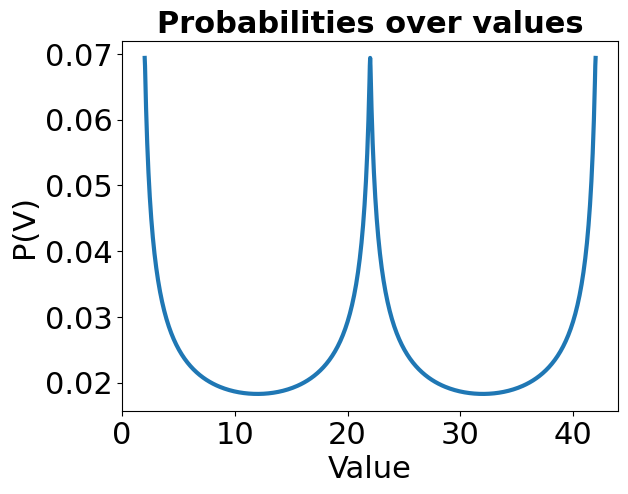

In [28]:

stim_val_grid, ps = tools.prior_val(type)

plt.plot(stim_val_grid, ps)

trapezoid(ps, stim_val_grid)

plt.ylabel("P(V)")
plt.xlabel("Value")
plt.title("Probabilities over values", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


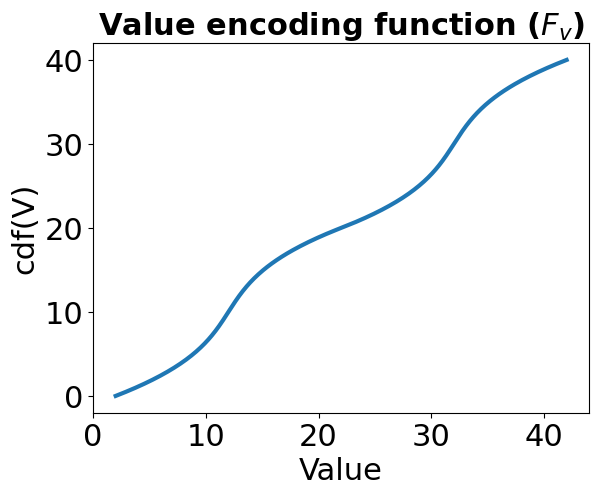

In [23]:
# stim_val_grid, ps = model.prior_val(type)
rep_val_grid, cdf_val = tools.cdf_val(type)

plt.plot(rep_val_grid, cdf_val)

plt.ylabel("cdf(V)")
plt.xlabel("Value")
plt.title("Value encoding function ($F_v$)", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


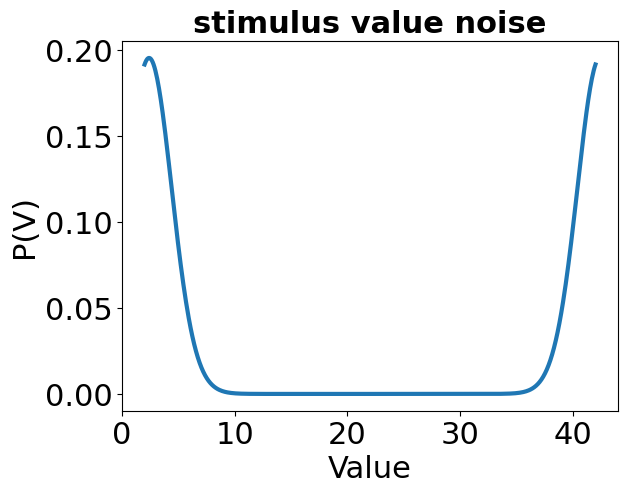

In [13]:
stim_val_grid, ps = tools.stimulus_val_noise(0.02*np.pi, 10, model.stim_ori_grid, type)

plt.plot(stim_val_grid, ps[0,:])

plt.ylabel("P(V)")
plt.xlabel("Value")
plt.title("stimulus value noise", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


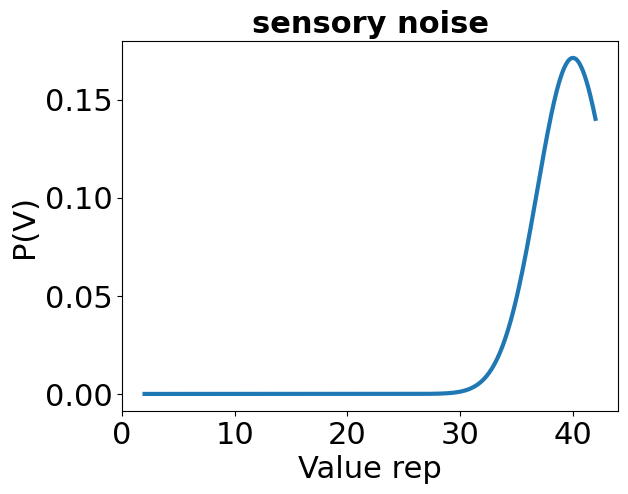

In [102]:
ps = tools.sensory_val_noise(40, np.sqrt(tools.factor_val/4), model.rep_val_grid)

plt.plot(tools.rep_val_grid, ps)

plt.ylabel("P(V)")
plt.xlabel("Value rep")
plt.title("sensory noise", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

# Start with business

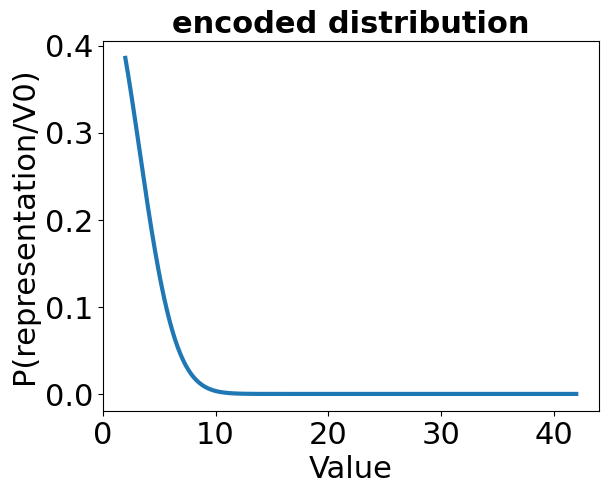

In [90]:

type = "linearIncrease"
theta0 = 0.36/90.*np.pi
kappa_s = 1000000
sigma_rep = np.sqrt(tools.factor_val/4)

p_m_given_theta0 = model.value_efficient_encoding(theta0, kappa_s, sigma_rep, type)

# p_m_given_theta[np.argsort(tools.value_function_ori(tools.stim_ori_grid, type))]

plt.plot(model.rep_val_grid, p_m_given_theta0[0])

# plt.plot(model.rep_val_grid, p_m_given_val[2])

plt.ylabel("P(representation/V0)")
plt.xlabel("Value")
plt.title("encoded distribution", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")



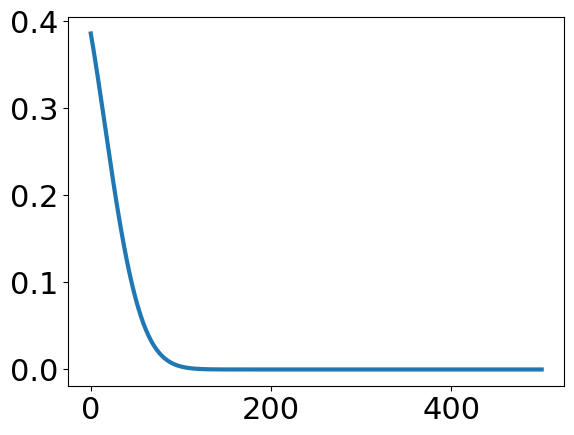

In [91]:
stim_val_grid, cdf_value = tools.cdf_val(type)
# Combine sensory and stimulus noise
p_m_given_theta0 = tools.sensory_val_noise(cdf_value[np.newaxis, :, np.newaxis], sigma_rep, tools.rep_val_grid[np.newaxis, np.newaxis, :]) * tools.stimulus_val_noise(theta0, kappa_s, tools.stim_ori_grid, type)[1][..., np.newaxis]
p_m_given_theta0 = trapezoid(p_m_given_theta0, stim_val_grid, axis=1)

plt.plot(p_m_given_theta0[0])


In [133]:
from scipy.optimize import minimize
type = "linearIncrease"
theta0 = 0.36/90.*np.pi
kappa_s = 1000000
sigma_rep = np.sqrt(tools.factor_val/64)
p_val = 2


stim_val_grid, cdf_value = tools.cdf_val(type)
# Make a big array that for many thetas (its actually values, varible not named 100 % right) gives the probability of observing ms (value likelihood)
p_m_given_theta = tools.sensory_val_noise(cdf_value[np.newaxis, :, np.newaxis], sigma_rep, tools.rep_val_grid[np.newaxis, np.newaxis, :]) * tools.stimulus_val_noise(tools.stim_ori_grid, kappa_s, tools.stim_ori_grid, type)[1][..., np.newaxis]
p_m_given_theta = trapezoid(p_m_given_theta, stim_val_grid, axis=1)

p_m_given_val = p_m_given_theta[np.argsort(tools.value_function_ori(tools.stim_ori_grid, type))]

safe_value, val_prior = tools.prior_val(type)

p_val_given_m = p_m_given_val*np.array(val_prior)[:, np.newaxis]
p_val_given_m = p_val_given_m / trapezoid(p_val_given_m, safe_value, axis=0)[np.newaxis,:]

x0 = trapezoid(safe_value[:, np.newaxis]*p_val_given_m, safe_value, axis=0)
if p_val == 2:
    val_estimates = x0

else:
    val_estimates = []
    for ix in range(len(x0)):
        cost_function = lambda valest: np.sum(p_val_given_m[:, ix] * np.abs(safe_value - valest)**(p_val))
        jacobian = lambda valest: -np.sum(p_val_given_m[:, ix] * (p_val * np.abs(safe_value - valest)**(p_val-1)))

        x = minimize(cost_function, x0[ix], method='BFGS', jac=jacobian).x[0]
        val_estimates.append(x)
    
    val_estimates = np.array(val_estimates)



39.12695327658483 38.96062768996783


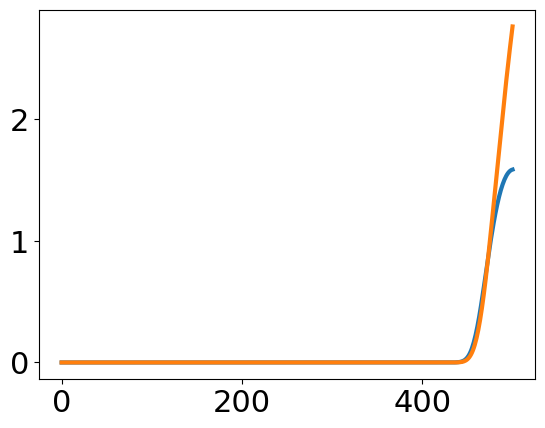

In [134]:
i = -4
j = -2

plt.plot(p_val_given_m[i])
plt.plot(p_val_given_m[j])
print(val_estimates[i],val_estimates[j])

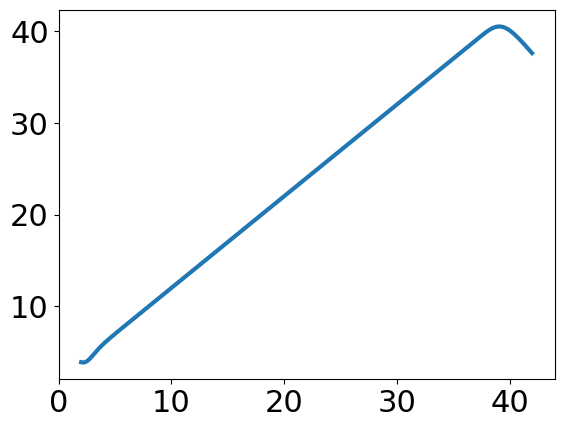

In [135]:

type = "linearIncrease"
theta0 = 5./90.*np.pi
kappa_s = 10000
sigma_rep = np.sqrt(tools.factor_val/64)
val_estimates = model.subject_val_estimate(kappa_s, sigma_rep, type, p_val=2)

plt.plot(model.rep_val_grid, val_estimates)
# val_estimates[-1]

In [128]:
print(val_estimates[-2], val_estimates[-4])


38.8469231430231 39.006855549132425


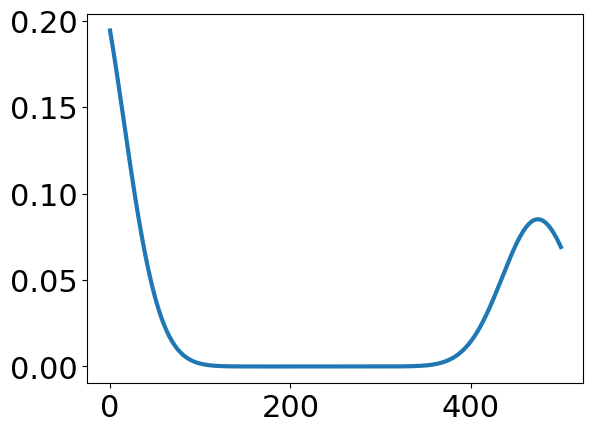

In [39]:
stim_val_grid, cdf_value = tools.cdf_val(type)
# Make a big array that for many thetas (its actually values, varible not named 100 % right) gives the probability of observing ms (value likelihood)
p_m_given_theta = tools.sensory_val_noise(cdf_value[np.newaxis, :, np.newaxis], sigma_rep, tools.rep_val_grid[np.newaxis, np.newaxis, :]) *(tools.stimulus_val_noise(tools.stim_ori_grid, kappa_s, tools.stim_ori_grid, type)[1])[..., np.newaxis]
p_m_given_theta = trapezoid(p_m_given_theta, stim_val_grid, axis=1)

# p_m_given_val = p_m_given_theta[np.argsort(tools.value_function_ori(tools.stim_ori_grid, type))]

# safe_value, val_prior = tools.prior_val(type)

# p_val_given_m = p_m_given_val*np.array(val_prior)[:, np.newaxis]
# p_val_given_m = p_val_given_m / trapezoid(p_val_given_m, safe_value, axis=0)[np.newaxis,:]

# x0 = trapezoid(safe_value[:, np.newaxis]*p_val_given_m, safe_value, axis=0)
# if p_val == 2:
#     val_estimates = x0

# else:
#     val_estimates = []
#     for ix in range(len(x0)):
#         cost_function = lambda valest: np.sum(p_val_given_m[:, ix] * np.abs(safe_value - valest)**(p_val))
#         jacobian = lambda valest: -np.sum(p_val_given_m[:, ix] * (p_val * np.abs(safe_value - valest)**(p_val-1)))

#         x = minimize(cost_function, x0[ix], method='BFGS', jac=jacobian).x[0]
#         val_estimates.append(x)
    
#     val_estimates = np.array(val_estimates)

plt.plot(p_m_given_val[0])

In [ ]:
ikelihood)
p_m_given_theta = tools.sensory_val_noise(cdf_value[np.newaxis, :, np.newaxis], sigma_rep, tools.rep_val_grid[np.newaxis, np.newaxis, :]) /*
(tools.stimulus_val_noise(tools.stim_ori_grid, kappa_s, tools.stim_ori_grid, type)[1])[..., np.newaxis]
p_m_given_theta = trapezoid(p_m_given_theta, stim_val_grid, axis=1)

# p_m_given_val = p_m_given_theta[np.argsort(tools.value_function_ori(tools.stim_ori_grid, type))]

# safe_value, val_prior = tools.prior_val(type)

# p_val_given_m = p_m_given_val*np.array(val_prior)[:, np.newaxis]
# p_val_given_m = p_val_given_m / trapezoid(p_val_given_m, safe_value, axis=0)[np.newaxis,:]

# x0 = trapezoid(safe_value[:, np.newaxis]*p_val_given_m, safe_value, axis=0)
# if p_val == 2:
#     val_estimates = x0

# else:
#     val_estimates = []
#     for ix in range(len(x0)):
#         cost_function = lambda valest: np.sum(p_val_given_m[:, ix] * np.abs(safe_value - valest)**(p_val))
#         jacobian = lambda valest: -np.sum(p_val_given_m[:, ix] * (p_val * np.abs(safe_value - valest)**(p_val-1)))

#         x = minimize(cost_function, x0[ix], method='BFGS', jac=jacobian).x[0]
#         val_estimates.append(x)
    
#     val_estimates = np.array(val_estimates)

plt.plot(p_m_given_val[0])

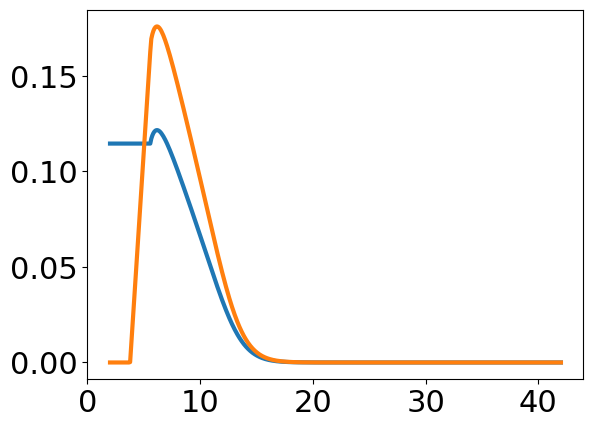

In [4]:
from scipy.interpolate import CubicSpline

val_estimates = model.subject_val_estimate(kappa_s, sigma_rep, type, p_val = 2)
grad_val = np.abs(np.gradient(val_estimates, model.rep_val_grid))
safe_value, val_prior = tools.prior_val(type)
p_value_est_given_theta0 = p_m_given_theta0 / grad_val[np.newaxis, :]

p_value_est_given_theta0_method_1 = np.array([np.interp(safe_value, val_estimates, p_value_est_given_theta0[ix]) for ix in range(len(p_value_est_given_theta0))])

for ix in range(len(p_value_est_given_theta0)):
    f = interp1d(val_estimates, p_value_est_given_theta0[ix], fill_value="extrapolate")
    interpolated_values = f(safe_value)
    interpolated_values = np.maximum(interpolated_values, 0)
    p_value_est_given_theta0[ix] = interpolated_values

    # f = CubicSpline(val_estimates, p_value_est_given_theta0[ix], extrapolate=True)
    # interpolated_values = f(safe_value)
    # interpolated_values = np.maximum(interpolated_values, 0)
    # p_value_est_given_theta0[ix] = interpolated_values

p_value_est_given_theta0_method_1/= trapezoid(p_value_est_given_theta0_method_1, safe_value, axis=1)[:, np.newaxis]
p_value_est_given_theta0 /= trapezoid(p_value_est_given_theta0, safe_value, axis=1)[:, np.newaxis]
plt.plot(safe_value, p_value_est_given_theta0_method_1[0])
plt.plot(safe_value, p_value_est_given_theta0[0])
# print(val_estimates)

34.199999999999996
[[0.40497669]]


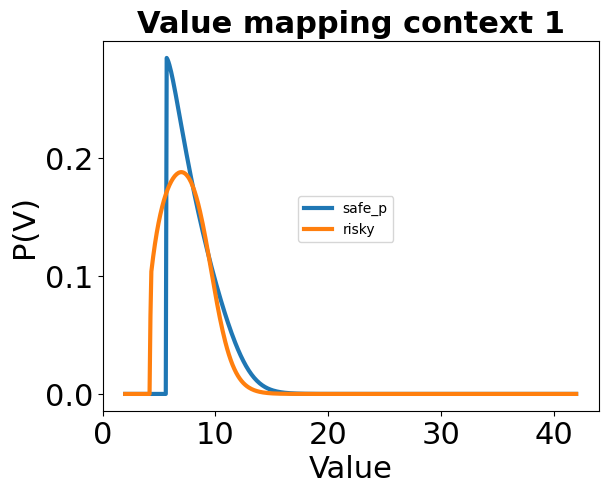

In [5]:

theta0 = 21/90.*np.pi
kappa_s = 10000
sigma_rep = np.sqrt(tools.factor_val/4) # The division is with teh analog of kappa

risk_prob = 0.75
type = "cdf_prior"
theta1 = float(tools.inverse_monotonic(tools.value_function_ori(theta0, type)/risk_prob, type))

print(theta1*90/np.pi)

# print(tools.value_function_ori(theta0, type))
# safe_value, safe_prob = model.value_bayesian_decoding(theta0, kappa_s, sigma_rep, type)
safe_value_p, safe_prob_p = model.experimenter_val_obs(theta0, kappa_s, sigma_rep, type, p_val = 2)
rr, risky_prob = model.risky_value_dist(theta1, kappa_s, sigma_rep, risk_prob, type, p_val = 2)

# print((np.angle(np.dot(np.exp(1j*((safe_value-2)/40*2*np.pi)), np.squeeze(safe_prob)))%(2*np.pi))/2/np.pi*40 + 2)


# plt.plot(safe_value, safe_prob[0], label = "safe")
plt.plot(safe_value_p, safe_prob_p[0], label = "safe_p")
plt.plot(rr, risky_prob[0], label = "risky")

p_chose_risky = tools.diff_dist(safe_value_p, risky_prob, safe_prob_p)
print(p_chose_risky)

plt.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})
plt.xlabel("Value")
plt.ylabel("P(V)")
plt.title("Value mapping context 1", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")


# Value biases already

0.5421020375529455

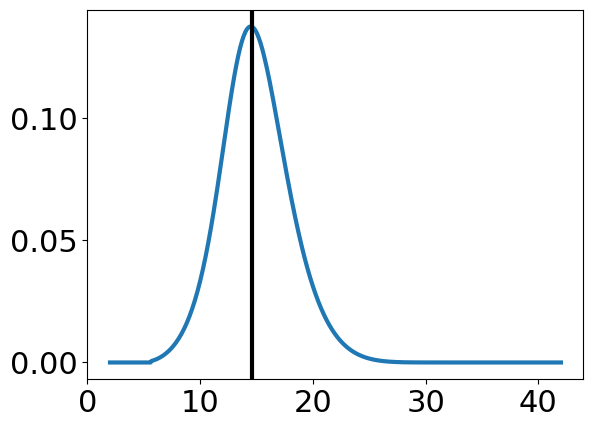

In [8]:

theta0 = 60/90.*np.pi
kappa_s = 10000
sigma_rep = np.sqrt(tools.factor_val/4) # The division is with teh analog of kappa

risk_prob = 0.75
type = "cdf_prior"
val0 = tools.value_function_ori(theta0, type)

safe_value, safe_prob = model.experimenter_val_obs(theta0, kappa_s, sigma_rep, type, p_val = 2)


plt.plot(safe_value, safe_prob[0])
plt.axvline(x = val0, color = "k")

tools.dist_greater(safe_value, safe_prob, val0)

# plt.xlabel("Value")
# plt.ylabel("P(V)")
# plt.title("Value mapping context 1", size = 22,fontweight="bold")

In [ ]:
type = "scaled_cdf"

kappa_s = 10000
sigma_rep_l = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]

end = int(tools.experimentRange[-3:])-1
start = int(tools.experimentRange[0:2])+1
end = end/90.*np.pi
start = start/90.*np.pi
    
signs = ["x", "o", ".", "v"] 
colorList = ["b", "r", "g", "m", "y", "k"]
alphaList = np.linspace(0.3, 1.0, len(sigma_rep_l))

fig = plt.figure()
ax1 = fig.add_subplot(111)


safe_angles = np.linspace(start, end, int((start*90/np.pi+end*90/np.pi-1)/3))
k = -1
for sigma_rep in sigma_rep_l:
    k = k+1
    prob_greater_perception = np.zeros(len(safe_angles))
    safe_Val_presented = tools.value_function_ori(safe_angles, type)
    plot_lines = []

    for i in range(len(safe_angles)):
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], kappa_s, sigma_rep, type, p_val = 2)

        prob = tools.dist_greater(safe_value, safe_prob, safe_Val_presented[i])
        prob_greater_perception[i] = prob

        print(prob)
        print(safe_angles[i]*90/np.pi)

        if k == 2:
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(111)
            labels = ["Inferred value from presented angle", "True value corresponding to presented angle"]

            l1, = ax2.plot(safe_value, safe_prob[0], color = "b", label=labels[0])
            l2 = ax2.axvline(x = safe_Val_presented[i], color = "k", label=labels[1])
            plot_lines.append([l1, l2])
            # plt.ylim(bottom=0, top=0.3)
            text = "Probability of inferred value being greater = "+str(round(prob, 2))
            ax2.set_xlabel("Values")
            ax2.set_ylabel("Probability distribution")
            if type == "scaled_cdf":
                ax2.set_title("Predicted discrepancies between\n inferred and presented value from value model", fontdict={"fontsize": 14, "fontweight": "bold"})
            else:
                ax2.set_title("Predicted discrepancies between\n inferred and presented value from value model", fontdict={"fontsize": 14, "fontweight": "bold"})

            # ax2.ylim(0.4, 0.6)
            ax2.text(0.4,0.05, text, style='italic', bbox={'facecolor': 'red', 'alpha': 0.4, 'pad': 3},  fontsize=10)
            ax2.legend(handles=[l1, l2], labels=labels,  fontsize=10, loc = "upper right")
            fig2.savefig(f'/Users/sbedi/Downloads/value%02d.png'%i,dpi=300, bbox_inches = "tight")
 
        # plt.show()
        
    # ax1.set_ylim(0.4, 0.6)
    ax1.plot(safe_angles*90./np.pi, prob_greater_perception, color=colorList[2], alpha = alphaList[k], label="Stim encoding noise - "+str(round(sigma_rep,2)))
    ax3 = ax1.twiny()
    ax3.plot(safe_Val_presented, np.ones(len(safe_Val_presented))/1.3, alpha=0.0)

ax1.axhline(0.5, c='k', ls='--')
ax1.set_xlabel("Angles")
ax3.set_xlabel("Values")
# if type == "scaled_cdf":
#     ax1.set_title("value mapping - "+ str(tools.scaling) + type+"; Perceptual model : Probability of\n Inferred value > corresponding presented angle value", fontdict={"fontsize": 14, "fontweight": "bold"})
# else:
ax1.set_title(type+" type; Value model : Probability of\n Inferred value > corresponding presented angle value", fontdict={"fontsize": 14, "fontweight": "bold"})

# noiseText = "stimulus noise ($\kappa_s$) = "+str(kappa_s)+ ";\n val encoding noise ($\kappa_r) = $"+str(kappa_r)
# ax1.text(0.4,0.3, noiseText, style='italic', bbox={'facecolor': 'red', 'alpha': 0.4, 'pad': 3},  fontsize=10)


ax1.axhline(0.5, c='k', ls='--')
ax1.set_ylabel("Probability")

ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})
fig.savefig(f'/Users/sbedi/Downloads/valModelSingleOption'+str(i)+'.png',dpi=300, bbox_inches = "tight")
fig.show()

1.0
1.0
1.0
4.06896551724138
1.0
7.137931034482759
0.5469145202901908
10.206896551724139
0.47007769344979855
13.27586206896552
0.4727426619944044
16.344827586206904
0.510423219940566
19.41379310344828
0.5134294310130674
22.482758620689662
0.522658897078399
25.551724137931043
0.509901919718037
28.62068965517242
0.4987861060132709
31.689655172413804
0.5301197854862305
34.75862068965518
0.5174215359101567
37.82758620689656
0.5060865512168551
40.896551724137936
0.49432332040059623
43.96551724137932
0.5248692780045365
47.0344827586207
0.5130400252161733
50.10344827586208
0.5446905985887587
53.17241379310346
0.5103633224352762
56.24137931034484
0.5201645554882504
59.31034482758622
0.5087536162258003
62.3793103448276
0.5395128999194243
65.44827586206897
0.5272598002584532
68.51724137931036
0.51592916863364
71.58620689655173
0.5037182161358517
74.65517241379312
0.5344270611644283
77.72413793103449
0.5229718877879831
80.79310344827587
0.5540866106447481
83.86206896551725
0.5200600916849405
86.9

/var/folders/fg/ps8b9dqs3b3cgp4jb85dxwfnsyv51d/T/ipykernel_57149/1666220612.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


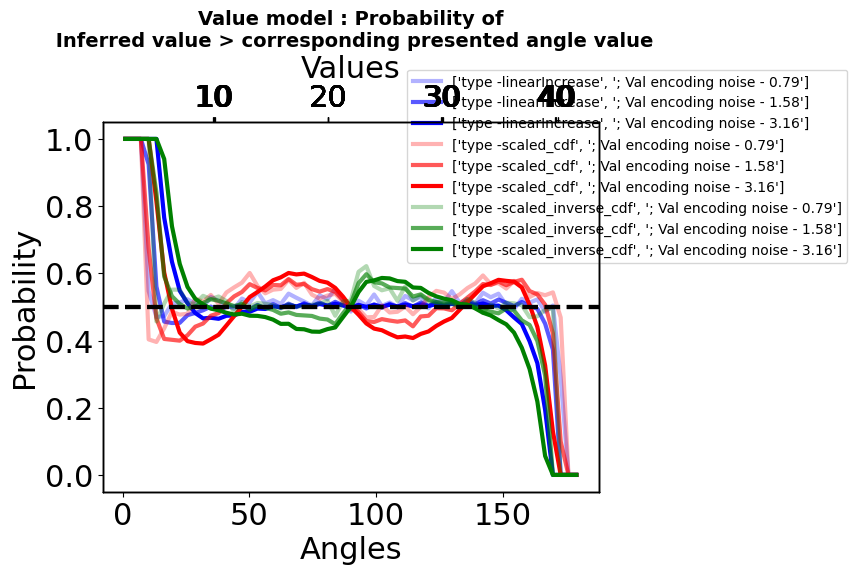

In [144]:
# Effect of types on value inference process

types = ["linearIncrease", "scaled_cdf", "scaled_inverse_cdf"]

kappa_s = 10000
sigma_repl = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]

end = int(tools.experimentRange[-3:])-1
start = int(tools.experimentRange[0:2])+1
end = end/90.*np.pi
start = start/90.*np.pi
    
signs = ["x", "o", ".", "v"] 
colorList = ["b", "r", "g", "m", "y", "k"]
alphaList = np.linspace(0.3, 1.0, len(sigma_repl))

fig = plt.figure()
ax1 = fig.add_subplot(111)


safe_angles = np.linspace(start, end, int((start*90/np.pi+end*90/np.pi-1)/3))

for j, type in enumerate(types):
    k = -1
    for sigma_rep in sigma_repl:
        k = k+1
        prob_greater_perception = np.zeros(len(safe_angles))
        safe_Val_presented = tools.value_function_ori(safe_angles, type)
        plot_lines = []

        for i in range(len(safe_angles)):
            safe_value, safe_prob = model.safe_value_dist(safe_angles[i], kappa_s, sigma_rep, type, p_val = 2)

            prob = tools.dist_greater(safe_value, safe_prob, safe_Val_presented[i])
            prob_greater_perception[i] = prob

            print(prob)
            print(safe_angles[i]*90/np.pi)

        
        # ax1.set_ylim(0.4, 0.6)
        ax1.plot(safe_angles*90./np.pi, prob_greater_perception, color=colorList[j], alpha = alphaList[k], label=["type -"+type, "; Val encoding noise - "+str(round(sigma_rep,2))])
        ax3 = ax1.twiny()
        ax3.plot(safe_Val_presented, np.ones(len(safe_Val_presented))/1.3, alpha=0.0)

ax1.axhline(0.5, c='k', ls='--')
ax1.set_xlabel("Angles")
ax3.set_xlabel("Values")
# if type == "scaled_cdf":
#     ax1.set_title("value mapping - "+ str(tools.scaling) + type+"; Perceptual model : Probability of\n Inferred value > corresponding presented angle value", fontdict={"fontsize": 14, "fontweight": "bold"})
# else:
ax1.set_title("Value model : Probability of\n Inferred value > corresponding presented angle value", fontdict={"fontsize": 14, "fontweight": "bold"})

# noiseText = "stimulus noise ($\kappa_s$) = "+str(kappa_s)+ ";\n val encoding noise ($\kappa_r) = $"+str(kappa_r)
# ax1.text(0.4,0.3, noiseText, style='italic', bbox={'facecolor': 'red', 'alpha': 0.4, 'pad': 3},  fontsize=10)


ax1.axhline(0.5, c='k', ls='--')
ax1.set_ylabel("Probability")

ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})
fig.savefig(f'/Users/sbedi/Downloads/valModelSingleOption'+str(i)+'.png',dpi=300, bbox_inches = "tight")
fig.show()

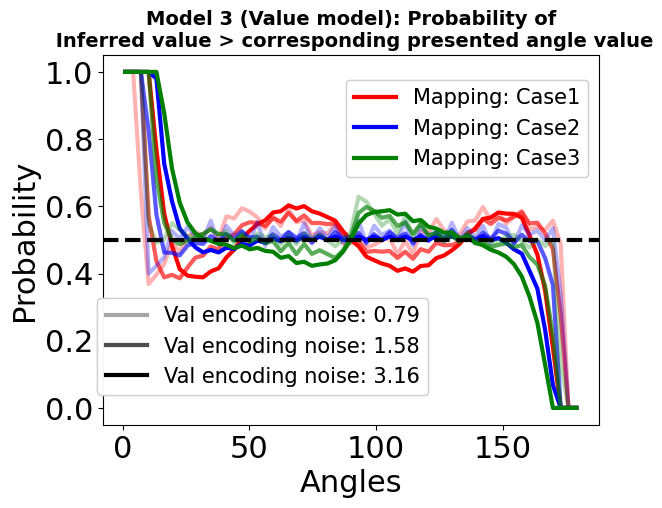

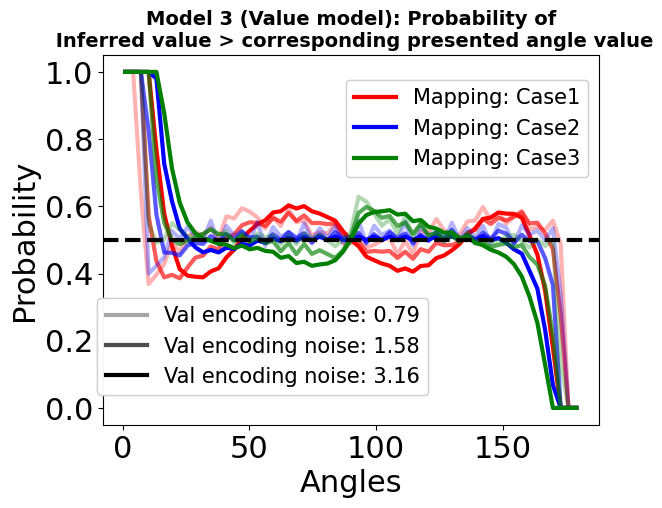

In [4]:
# Effect of types on value inference process

types = ["scaled_cdf", "linearIncrease", "scaled_inverse_cdf"]

kappa_s = 1000000
sigma_repl = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]

end = int(tools.experimentRange[-3:])-1
start = int(tools.experimentRange[0:2])+1
end = end/90.*np.pi
start = start/90.*np.pi
    
signs = ["x", "o", ".", "v"] 
colorList = ["r", "b", "g", "m", "y", "k"]
alphaList = np.linspace(0.3, 1.0, len(sigma_repl))

fig = plt.figure()
ax1 = fig.add_subplot(111)

safe_angles = np.linspace(start, end, int((start * 90 / np.pi + end * 90 / np.pi - 1) / 3))

# Plot lines for the type legend
type_lines = []
for j, type in enumerate(types):
    line = None  # Keep track of the legend line for each type
    for k, sigma_rep in enumerate(sigma_repl):
        prob_greater_perception = np.zeros(len(safe_angles))
        safe_Val_presented = tools.value_function_ori(safe_angles, type)

        for i in range(len(safe_angles)):
            safe_value, safe_prob = model.safe_value_dist(safe_angles[i], kappa_s, sigma_rep, type, p_val=2)
            prob = tools.dist_greater(safe_value, safe_prob, safe_Val_presented[i])
            prob_greater_perception[i] = prob

        # Plot lines for each sigma_rep for each type
        line = ax1.plot(
            safe_angles * 90. / np.pi,
            prob_greater_perception,
            label=f"type - Case "+str(j) if k == 1 else None,
            color=colorList[j], alpha = alphaList[k]
        )
    if line:
        type_lines.append(line[0])

# Create the type legend
ax1.axhline(0.5, c='k', ls='--')
ax1.set_xlabel("Angles")
ax1.set_title(
    "Model 3 (Value model): Probability of\n Inferred value > corresponding presented angle value",
    fontdict={"fontsize": 14, "fontweight": "bold"}
)
ax1.set_ylabel("Probability")

# Plot lines for the alpha legend
alpha_lines = []
for k, sigma_rep in enumerate(sigma_repl):
    # Dummy plot lines for the alpha legend
    line = ax1.plot([], [], alpha=alphaList[k], label=f"Val encoding noise - {round(sigma_rep, 2)}", color='k')
    alpha_lines.append(line[0])

# Create the first legend for mapping types
mapping_labels = ["Mapping: Case1", "Mapping: Case2", "Mapping: Case3"]
mapping_legend = fig.legend(type_lines, mapping_labels, loc="upper right", bbox_to_anchor=(0.9, 0.85), fontsize=15)

# Create the second legend for value encoding noises
noise_labels = [f"Val encoding noise: {round(sigma_rep, 2)}" for sigma_rep in sigma_repl]
noise_legend = fig.legend(alpha_lines, noise_labels, loc="lower right", bbox_to_anchor=(0.65, 0.15), fontsize=15)


# Add the legends to the figure
fig.gca().add_artist(mapping_legend)
fig.gca().add_artist(noise_legend)

# Show the figure
fig


# risk simulations

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns




# sns.set_context('talk|')?
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools

(0.7500031209345991, 0.26818308776310285)

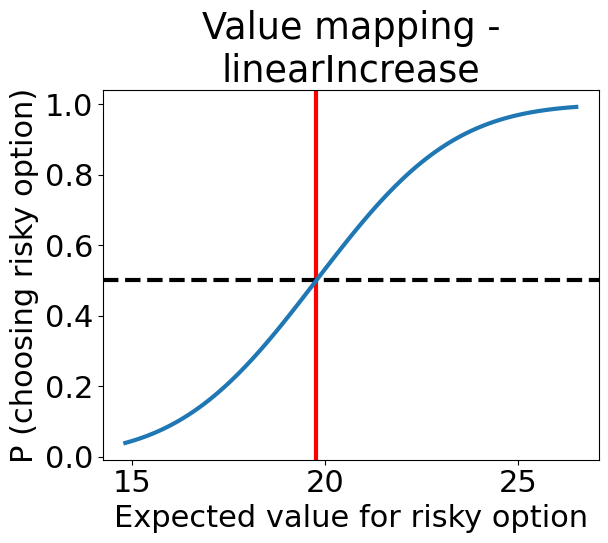

In [357]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "linearIncrease" 

stim_noise = 10000
rep_noise = np.sqrt(tools.factor_val/8)
start = 80/90*np.pi

# Getting all the values from actual transformation
interval = 70/90.*np.pi
if (type=="prior" or type=="linearDecrease" or type=="curvedPrior"):
    rangeOri = np.linspace(start, (start-interval), 100)
else:
    rangeOri = np.linspace(start, (start+interval), 100)

val_range = tools.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

# getting inferred safe values
safe_value, safe_prob = model.safe_value_dist(rangeOri[0], stim_noise, rep_noise, type, p_val = 2)
risky_value, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type, p_val = 2)


# # Risk attitudes 
p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
# plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky))#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)



# comparing models : same noise regimes fopr safe and risky option

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk|')
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np
import pandas as pd

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools


In [3]:
def rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type =="linearDecrease"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    slope = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("range - ", rangeOri)
        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, rep_noise , type, p_val = 2)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type, p_val = 2)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        # print(p_chose_risky[0,::2])
        rnp[i],slope[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp, slope



safe angle -  1.0
0.25910023710528446
safe angle -  4.125882352941177
0.46233316758794796
safe angle -  7.251764705882353
0.008479943245824816
safe angle -  10.377647058823527
0.7442557745429632
safe angle -  13.503529411764706
0.7852600789978987
safe angle -  16.629411764705882
0.7792676417011268
safe angle -  19.755294117647058
0.7647798092206098
safe angle -  22.881176470588237
0.7573038296048449
safe angle -  26.00705882352941
0.7550064244270793
safe angle -  29.132941176470585
0.7545596150386595
safe angle -  32.258823529411764
0.7544432216481713
safe angle -  35.38470588235294
0.7543691952438717
safe angle -  38.510588235294115
0.7540381258832634
safe angle -  41.63647058823529
0.7531157567722103
safe angle -  44.76235294117647
0.7518164882945509
safe angle -  47.88823529411764
0.7501777394456027
safe angle -  51.014117647058825
0.7481844433568586
safe angle -  54.13999999999999
0.7460298530257413
safe angle -  57.265882352941176
0.7443584915639666
safe angle -  60.39176470588234

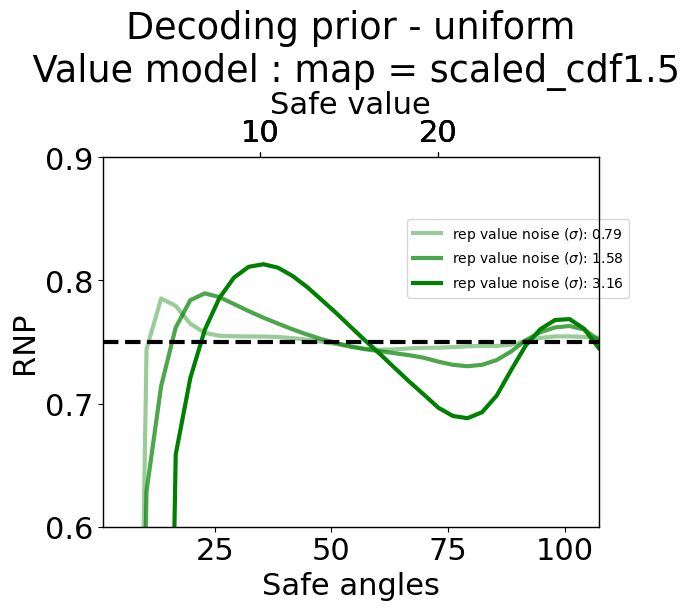

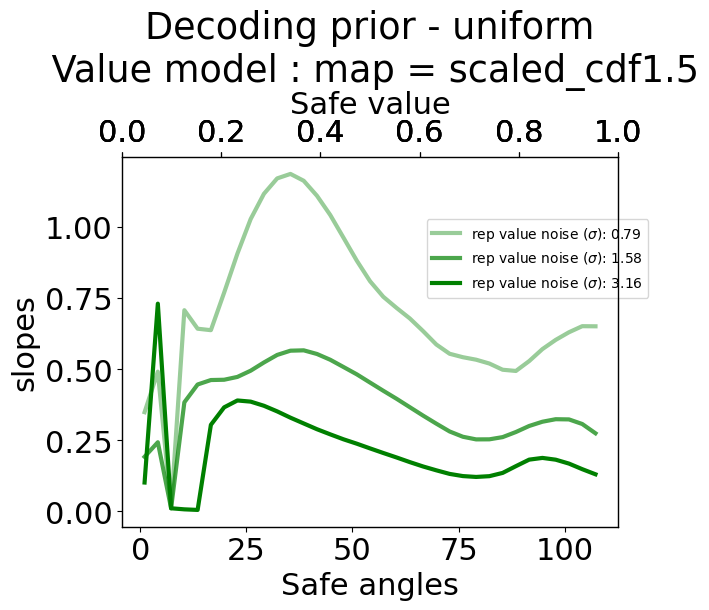

In [271]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    # stim_list = [64, 16, 8, 4]
    # rep_list = [np.sqrt(tools.factor_val/128)]


    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    fig1 = plt.figure()
    axa1 = fig1.add_subplot(111)

    alphaList = np.linspace(0.4, 1.0, len(rep_list))
    i = 0

    for stim_noise in stim_list:
        for rep_noise in rep_list:

            safe_angles, safeVals, rnp, slope = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
            ax1.set_ylim(0.6, 0.9)
            ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

            text = "rep value noise ($\sigma$): "+str(round(rep_noise,2))
            ax1.plot(safe_angles[:]*90./np.pi, rnp[:], color = "green", alpha = alphaList[i], label = text)

            ax2 = ax1.twiny()
            if (type=="linearDecrease"):
                ax2.set_xlim(max(safeVals), min(safeVals))

            ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)
            # axa1.set_ylim(0.0, 1.6)
            axa1.plot(safe_angles[:]*90./np.pi, slope[:], color='green', label = text, alpha =  alphaList[i])
            axa2 = axa1.twiny()
            i = i+1

    ax1.axhline(risk_prob, c='k', ls='--')
    ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")

    axa1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})
    axa2.set_xlabel("Safe value")
    axa1.set_xlabel("Safe angles")
    axa1.set_ylabel("slopes")
    if type == "scaled_cdf":
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Value model : map = " + type+str(tools.scaling)) 
        axa1.set_title("Decoding prior - " + tools.contextual_prior + "\n Value model : map = " + type+str(tools.scaling)) 
        fig.savefig("/Users/sbedi/Downloads/"+"RNP-valuation-"+str(tools.scaling)+type+".png",dpi=300, bbox_inches = "tight")
        fig1.savefig("/Users/sbedi/Downloads/"+"Slope-valuation-"+str(tools.scaling)+type+".png",dpi=300, bbox_inches = "tight")
    else:
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Value model : map = " + type) 
        axa1.set_title("Decoding prior - " + tools.contextual_prior + "\n Value model : map = " + type) 
        fig.savefig("/Users/sbedi/Downloads/"+"RNP-valuation-"+type+".png",dpi=300, bbox_inches = "tight")
        fig1.savefig("/Users/sbedi/Downloads/"+"Slope-valuation-"+type+".png",dpi=300, bbox_inches = "tight")



safe angle -  1.0
0.24847945185616563
safe angle -  4.111515151515151
0.011930661819160896
safe angle -  7.223030303030303
0.6618605978616102
safe angle -  10.334545454545454
0.7666280960734205
safe angle -  13.446060606060605
0.8007116563510075
safe angle -  16.55757575757576
0.7807939345385988
safe angle -  19.66909090909091
0.7632192748123154
safe angle -  22.780606060606058
0.7625442703177625
safe angle -  25.892121212121214
0.7585126489812326
safe angle -  29.00363636363636
0.7560646856263775
safe angle -  32.11515151515152
0.7552015892191069
safe angle -  35.22666666666667
0.7534031720047907
safe angle -  38.338181818181816
0.7519991283022371
safe angle -  41.44969696969697
0.7521044138958376
safe angle -  44.56121212121212
0.7502692097313682
safe angle -  47.67272727272727
0.748379653706925
safe angle -  50.78424242424242
0.7478848414893968
safe angle -  53.89575757575758
0.7461392425054647
safe angle -  57.00727272727273
0.7462453858130456
safe angle -  60.11878787878787
0.7437

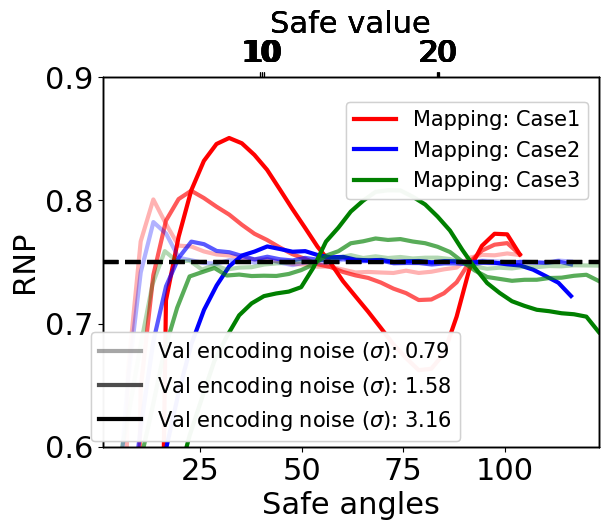

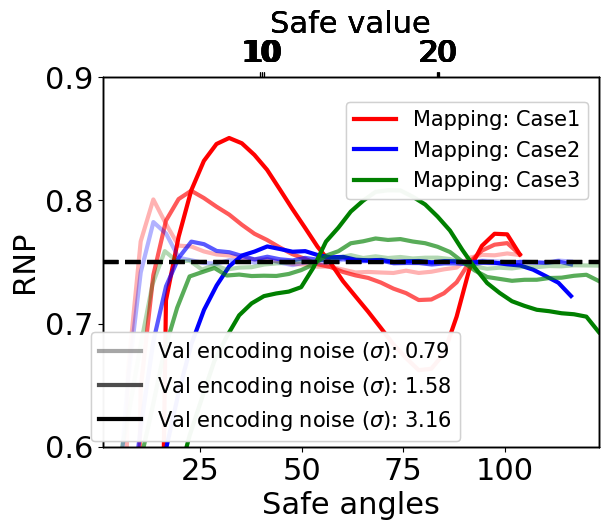

In [4]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["scaled_cdf", "linearIncrease", "scaled_inverse_cdf"]
# type = "curved_cdf_prior"

signs = ["x", "o", ".", "v"] 
colorList = ["r", "b", "g", "m", "y", "k"]
alphaList = np.linspace(0.3, 1.0, 3)
# alphaList = alphaList[np.argsort(sigma_rep)][::-1]

fig = plt.figure()
ax1 = fig.add_subplot(111)

j = -1
for type in types:
    j = j+1
    # changeable parameters
    stim_noise = 100000
    rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]

    i = 0
    for rep_noise in rep_list:

        safe_angles, safeVals, rnp, slope = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
        ax1.set_ylim(0.6, 0.9)
        ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

        text = "rep value noise ($\sigma$): "+str(round(rep_noise,2))
        ax1.plot(safe_angles[:]*90./np.pi, rnp[:], color = colorList[j], alpha = alphaList[i], label = text)

        ax2 = ax1.twiny()
        if (type=="linearDecrease"):
            ax2.set_xlim(max(safeVals), min(safeVals))

        ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

        i = i+1

    ax1.axhline(risk_prob, c='k', ls='--')

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")

# Create the first legend for mapping types
mapping_labels = ["Mapping: Case1", "Mapping: Case2", "Mapping: Case3"]
mapping_legend = fig.legend(type_lines, mapping_labels, loc="upper right", bbox_to_anchor=(0.9, 0.85), fontsize=15)

# Create the second legend for value encoding noises
noise_labels = [f"Val encoding noise ($\sigma$): {round(sigma_rep, 2)}" for sigma_rep in sigma_repl]
noise_legend = fig.legend(alpha_lines, noise_labels, loc="lower right", bbox_to_anchor=(0.7, 0.1), fontsize=15)


# Add the legends to the figure
fig.gca().add_artist(mapping_legend)
fig.gca().add_artist(noise_legend)

# Show the figure
fig


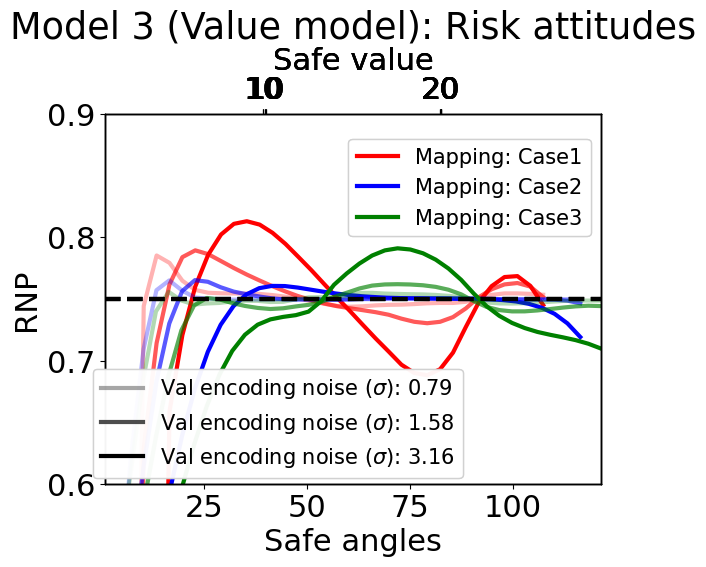

In [364]:
ax1.set_title("Model 3 (Value model): Risk attitudes")

fig

# different sensory noises fpr two options

In [8]:
def rnp_diffNoises(stim_noise, safe_rep_noise, risky_rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="curvedPrior" or type =="linearDecrease"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("range - ", rangeOri*90/np.pi)
        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # print("safeval - ", safeVal, "range val - ", val_range)

        # getting inferred safe values for the two different noise types forthe two options
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, safe_rep_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, risky_rep_noise, risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        print(p_chose_risky[0,::2])
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp



safe angle -  1.0
[0.29854341 0.30039128 0.3027099  0.30514167 0.30768749 0.31035382
 0.31314743 0.31607545 0.31914549 0.32236561]
0.22389252576345575
safe angle -  4.125882352941177
[0.2992778  0.30575184 0.31285885 0.32066505 0.32924305 0.33866729
 0.34901723 0.36037134 0.37280691 0.38639648]
0.4761691671207896
safe angle -  7.251764705882353
[0.29750193 0.31218431 0.32905011 0.34833041 0.37021336 0.39480408
 0.42208212 0.4518664  0.48378826 0.51729357]
0.6795994525908664
safe angle -  10.377647058823527
[0.28537458 0.3145743  0.34882141 0.387767   0.43043953 0.47534253
 0.52076044 0.56514501 0.6073969  0.64693405]
0.7667562436806326
safe angle -  13.503529411764706
[0.24744226 0.29360211 0.34576207 0.40086458 0.45624643 0.51033912
 0.56245749 0.61228084 0.65951826 0.70383571]
0.7802846755796727
safe angle -  16.629411764705882
[0.17765478 0.23236577 0.29384732 0.35987849 0.42898733 0.49947965
 0.56931877 0.63643929 0.6990814  0.7559797 ]
0.7671735582333966
safe angle -  19.755294117

TypeError: 'Line2D' object is not iterable

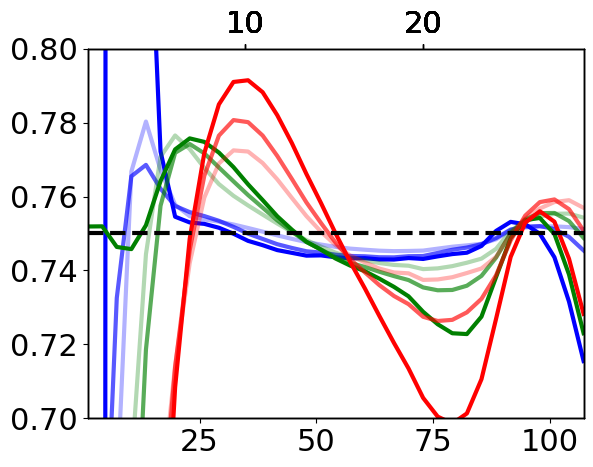

In [17]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    safe_rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    risky_rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    # High stim noise
    # stim_list = [64, 16, 8, 4]
    # rep_list = [128]

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    alphaList = np.linspace(0.3, 1.0, len(risky_rep_list))
    colorList = ["b", "g", "r", "c", "m", "y", "k"]
    plot_lines = []
    j = -1
    for stim_noise in stim_list:
        for safe_rep_noise in safe_rep_list:
            j = j+1
            i = -1
            for risky_rep_noise in risky_rep_list:
                i = i+1
                safe_angles, safeVals, rnp = rnp_diffNoises(stim_noise, safe_rep_noise, risky_rep_noise, type, risk_prob, experimentEffects)
                ax1.set_ylim(0.7, 0.8)
                ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

                text = "safe_rep ($\sigma$): "+str(round(safe_rep_noise, 2)) + "; risky_rep ($\sigma$): "+str(round(risky_rep_noise, 2))
                l, = ax1.plot(safe_angles[:]*90./np.pi, rnp[:], color=colorList[j], label = text, alpha =  alphaList[i])
                plot_lines.append(l)
                ax2 = ax1.twiny()
                if (type=="prior" or type=="curvedPrior" or type == "linearDecrease"):
                    ax2.set_xlim(max(safeVals), min(safe_angles))

                ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

    ax1.axhline(risk_prob, c='k', ls='--')
    legend1 = ax1.legend(plot_lines[0], ["low_noise", "med_noise", "high_noise"], loc=1)
    ax1.legend([l[0] for l in plot_lines], safe_rep_noise, loc=4)

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")
    if type == "scaled_cdf":
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Valuation model : " + type+str(tools.scaling)) 
    else:
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Valuation model : " + type) 

    plt.savefig("/Users/sbedi/Downloads/diffNoises-valuation"+tools.contextual_prior+".png",dpi=300, bbox_inches = "tight")
    

In [16]:
plot_lines
print(l[0] for l in plot_lines)

<generator object <genexpr> at 0x7fa26982ecf0>


# diff

In [ ]:

def rnp_safeVals_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)


        safeVal = tools.value_function_ori(safe_angles[i], type)
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.value_bayesian_decoding(safe_angles[i], safeNoise[0], safeNoise[1], type)
        risky_value, risky_prob = model.risky_value_dist((rangeOri), riskyNoise[0], riskyNoise[1], risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
    return safe_angles, safeVals, rnp

    

In [ ]:

# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "cdf_prior" 

# changeable parameters
high_stim_list = [32]
low_stim_list = [10000]
high_rep_list = [np.sqrt(tools.factor_val/8)]
low_rep_list = [np.sqrt(tools.factor_val/64)]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for high_stim_noise in high_stim_list:
    for high_rep_noise in high_rep_list:
        for low_stim_noise in low_stim_list:
            for low_rep_noise in low_rep_list:

                safeNoise = [low_stim_noise, high_rep_noise]
                riskyNoise = [high_stim_noise, low_rep_noise]

                safe_angles, safeVals, rnp = rnp_safeVals_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects)

                ax1.set_ylim(0.6, 0.85)

                text = "Safe stim (k): "+ str(safeNoise[0])+" Safe rep ($\sigma$): "+str(safeNoise[1])
                # text = "Risky stim (k): "+ str(riskyNoise[0])+"; Risky rep ($\sigma$): "+str(riskyNoise[1])


                ax1.plot(safeVals[:], rnp[:], label = text)

                ax2 = ax1.twiny()
                if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
                    ax2.set_xlim(max(safe_angles*90./np.pi), min(safe_angles*90./np.pi))
                ax2.plot(safe_angles*90./np.pi, np.ones(len(safe_angles))/1.3, alpha=0.0)

ax1.axhline(risk_prob, c='k', ls='--')
ax1.legend(bbox_to_anchor=(1.05, 0.9), prop={'size': 10})

ax2.set_xlabel("\n Safe angle")
ax1.set_xlabel("Safe Value")
ax1.set_ylabel("RNP")
# if len(safeNoise[0])==1 and len(safeNoise[1])==1:
# ax1.set_title("Value : " + type + "\n safe stim (k): "+str(safeNoise[0])+"; safe rep ($\sigma$): "+str(safeNoise[1]))
# else:
ax1.set_title("Value : " + type + "\n risky stim (k): "+str(riskyNoise[0])+" risky rep ($\sigma$): "+str(riskyNoise[1]))
plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

# just for a safe angle

In [ ]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "cdf_prior" 

stim_noise = 10000
rep_noise = 0.07
start = 80

# Getting all the values from actual transformation
interval = 50
rangeOri = np.linspace(start/90., (start+interval)/90., 100)*np.pi
val_range = tools.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)


# getting inferred safe values
safe_value, safe_prob = model.value_bayesian_decoding(rangeOri[0], stim_noise, rep_noise, type)
risky_value, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)


# # Risk attitudes 
p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
# plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky))#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

# plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)



In [ ]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["cdf_prior", "scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    # stim_list = [64, 16, 8, 4]
    # rep_list = [np.sqrt(tools.factor_val/128)]


    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    for stim_noise in stim_list:
        for rep_noise in rep_list:

            safe_angles, safeVals, rnp = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
            ax1.set_ylim(0.7, 0.8)
            ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

            text = "stim (k): "+ str(stim_noise)+"; rep ($\sigma$): "+str(round(rep_noise,2))
            ax1.plot(safe_angles[:]*90./np.pi, rnp[:], label = text)


            ax2 = ax1.twiny()
            if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
                ax2.set_xlim(max(safeVals), min(safe_angles))

            ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

    ax1.axhline(risk_prob, c='k', ls='--')
    ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")
    if type == "scaled_cdf":
        ax1.set_title("Exp range - " + tools.experimentRange + "\n Value model : " + type+str(tools.scaling)) 
    else:
        ax1.set_title("Exp range - " + tools.experimentRange + "\n Value model : " + type) 

    plt.savefig("/Users/sbedi/Downloads/"+tools.contextual_prior+"-valuation-.png",dpi=300, bbox_inches = "tight")
   